In [ ]:
%load_ext autoreload
%autoreload 2

# Memory Information and GPU Information



In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.69GB
Available: 11.88GB
Used: 545.77MB
Percentage: 6.3%


In [ ]:
! nvidia-smi

Thu Jun  3 16:12:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Targets Expectations

To converge the Loss, the LR of 0.01 is may be not the correct way, but using lower LR may take ages, so we will use a LR Scheduler, in particular StepLR to reduce the Lr after certain number of epochs, where we feel the Loss is bouncing.

**Parameters**: Less than 8,000  
**Data Augmentations**: RandomRotation ±15°  
**Regularization**: DropOut  
**LR Scheduler**: StepLR  
**No. of Epochs**: 14


# Imports

In [ ]:
!git clone https://github.com/EVA6-Group-15/DLUtils.git dlutils

Cloning into 'dlutils'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 13 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import dlutils.plotter as plotter
import dlutils.train as train
import dlutils.test as test

# Data

In [ ]:
train_data_ = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor()]))

In [ ]:
plotter.data_stats(train_data_)

Train Statistics
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [ ]:
torch.manual_seed(1)
batch_size = 64

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_data = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-15.0,15.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))]))
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,
                                           shuffle=True, **kwargs)

test_data = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))]))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=True, **kwargs)

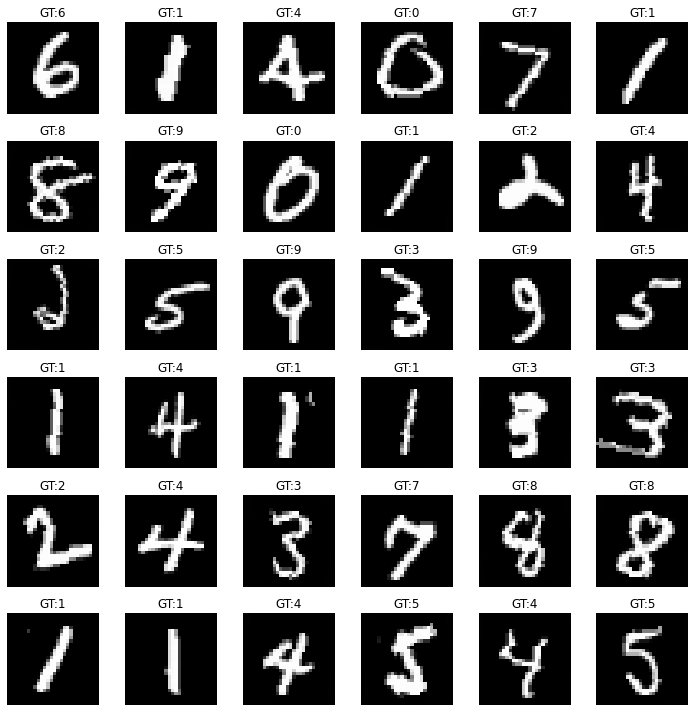

In [ ]:
class_list = [0,1,2,3,4,5,6,7,8,9]
plotter.plot_data_grid(train_loader, mean= (0.1307,), std= (0.3081,), class_list=class_list, ncol=6,nrow=6)

# Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            # 28x28x1 -> 26x26x4
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=8),
            # 26x26x4 -> 24x24x8
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, bias=False),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(),
            # 24x24x8 -> 12x12x8
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        self.layer2 =  nn.Sequential(
            # 12x12x8 -> 10x10x8
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=12),
            # 10x10x8 -> 8x8x8
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=12),
            # 8x8x8 -> 6x6x16
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=16),
            # 6x6x16 -> 4x4x16
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, bias=False)
        )
        
        self.gap = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1),
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=1)

        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.gap(x)
        x = self.classifier(x)
        x = x.view(-1,10)

        return F.log_softmax(x, dim=1)

In [ ]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4            [-1, 8, 24, 24]             576
       BatchNorm2d-5            [-1, 8, 24, 24]              16
              ReLU-6            [-1, 8, 24, 24]               0
         MaxPool2d-7            [-1, 8, 12, 12]               0
            Conv2d-8           [-1, 12, 10, 10]             864
              ReLU-9           [-1, 12, 10, 10]               0
      BatchNorm2d-10           [-1, 12, 10, 10]              24
           Conv2d-11             [-1, 12, 8, 8]           1,296
             ReLU-12             [-1, 12, 8, 8]               0
      BatchNorm2d-13             [-1, 12, 8, 8]              24
           Conv2d-14             [-1, 1

# Training

In [ ]:
from torch.optim.lr_scheduler import StepLR

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 6, gamma= 0.1)
trainer = train.Train(model, device, train_loader, optimizer)
tester = test.Test(model, device, test_loader)

for epoch in range(1, 15):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = trainer()
    scheduler.step()
    test_loss, test_acc = tester()
    
    print('TRAIN set: Average loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss,train_acc), end=' | ')
    print('TEST set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss,test_acc))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


loss=0.14653590321540833 batch_id=937: 100%|██████████| 938/938 [00:19<00:00, 48.94it/s]


TRAIN set: Average loss: 0.2771, Train Accuracy: 91.25% | TEST set: Average loss: 0.0570, Test Accuracy: 98.16%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2
TRAIN set: Average loss: 0.0690, Train Accuracy: 97.85% | TEST set: Average loss: 0.0427, Test Accuracy: 98.74%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3
TRAIN set: Average loss: 0.0576, Train Accuracy: 98.14% | TEST set: Average loss: 0.0273, Test Accuracy: 99.24%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4
TRAIN set: Average loss: 0.0500, Train Accuracy: 98.41% | TEST set: Average loss: 0.0373, Test Accuracy: 98.85%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5
TRAIN set: Average loss: 0.0466, Train Accuracy: 98.51% | TEST set: Average loss: 0.0257, Test Accuracy: 99.28%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6
TRAIN set: Average loss: 0.0426, Train Accuracy: 98.65% | TEST set: Average loss: 0.0283, Test Accur

In [ ]:
print('Train Accuracy:', max(trainer.accuracy))
print('Test Accuracy:', max(tester.accuracy))

Train Accuracy: 99.165
Test Accuracy: 99.48


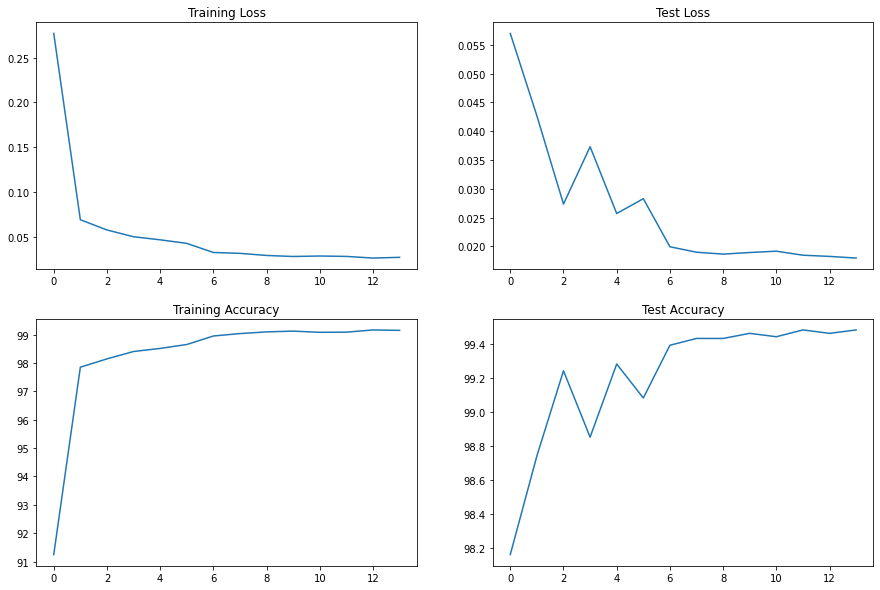

In [ ]:
plotter.plot_loss_acc(trainer.loss, trainer.accuracy, tester.loss, tester.accuracy)

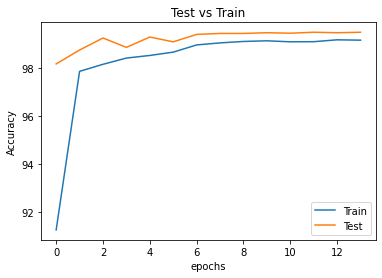

In [ ]:
plotter.plot_combined(trainer.accuracy, tester.accuracy,  x_label='epochs', y_label='Accuracy')

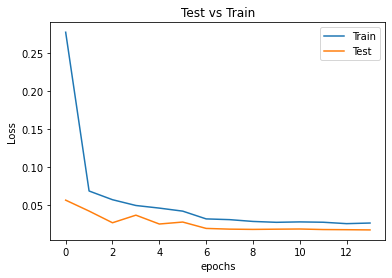

In [ ]:
plotter.plot_combined(trainer.loss, tester.loss,  x_label='epochs', y_label='Loss')

In [ ]:
class_list = [0,1,2,3,4,5,6,7,8,9]
mean= (0.1307,)
std= (0.3081,)
results = plotter.Results(model, test_loader, device, mean, std, class_list)

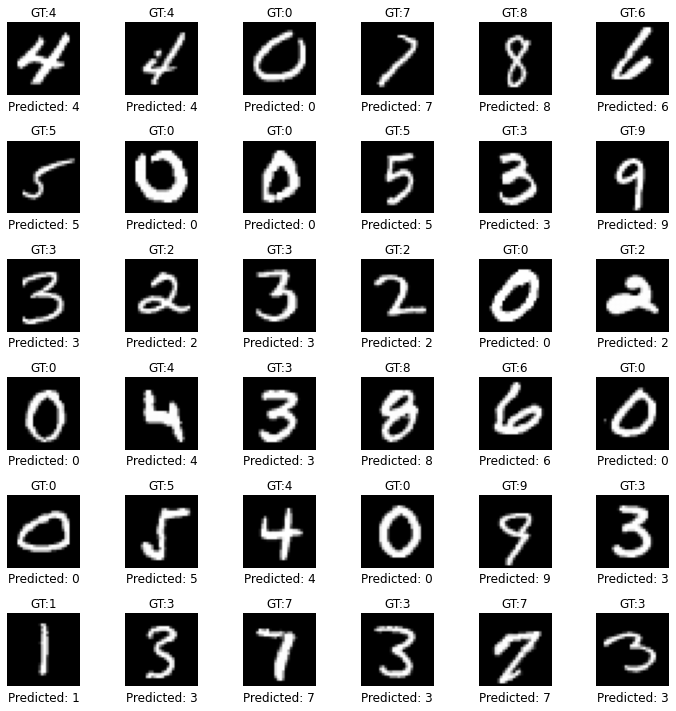

In [ ]:
results.plot_batch()

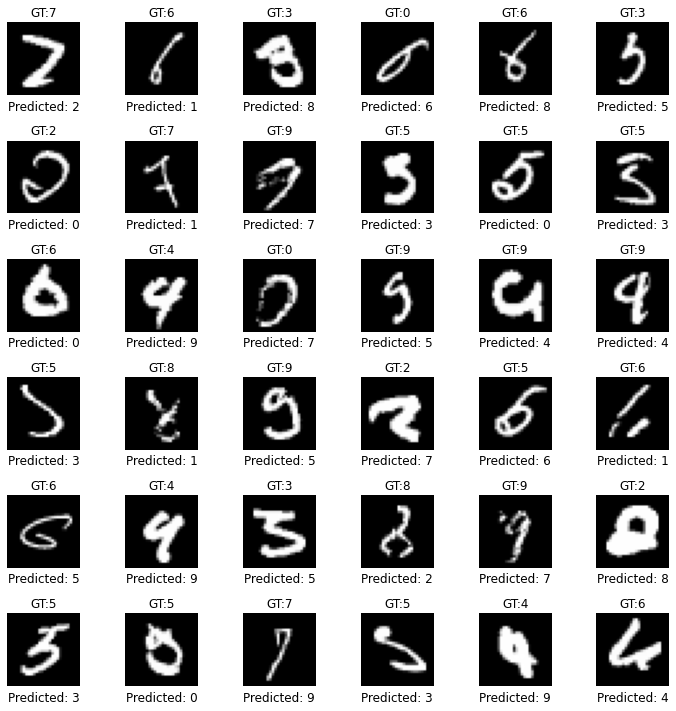

In [ ]:
results.plot_incorrect()

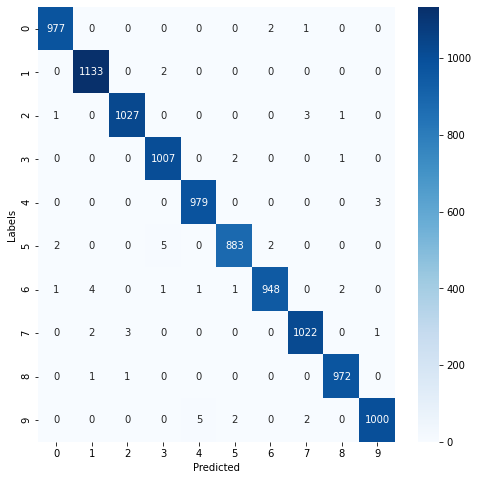

Accuracies of Top 10 Classes in Decreasing Order
Accuracy of class 6 is 98.96
Accuracy of class 5 is 98.99
Accuracy of class 9 is 99.11
Accuracy of class 7 is 99.42
Accuracy of class 2 is 99.52
Accuracy of class 0 is 99.69
Accuracy of class 4 is 99.69
Accuracy of class 3 is 99.70
Accuracy of class 8 is 99.79
Accuracy of class 1 is 99.82


In [ ]:
results.class_accuracy()

# Model Architecture

In [ ]:
!pip3 install hiddenlayer

In [ ]:
import hiddenlayer as hl
model = Net().to('cuda')
network_graph = hl.build_graph(model, torch.zeros([1, 1, 28, 28]).to('cuda'))
network_graph.save("./images/network_1", "png")

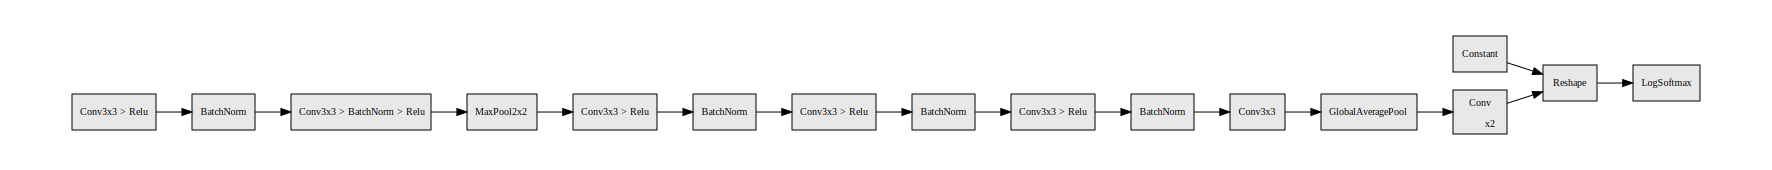

In [ ]:
network_graph

# Acheivements

**Total Parameters Used**: 7,826  
**Train Accuracy**: 99.165  
**Test Accuracy**: **99.48**  
**Consistent From**: **7th Epoch to End**  
**Data Augmentation**: Randam Rotation of ±15°  
**LR Scheduler**: StepLR

## Analysis

The StepLR helped in stabilizing the learning, by reducing the learning rate to 10% after every 6th Epochs.

Why after every 6 epochs?  
We observed that the Loss was bouncing up and down, from 6th/7th epoch, so reducing the LR at that point would made the training stable.

And we can clearly see that the Accuracy/Loss in Testing is Bouncing heavily in the first 6 epochs, and after 6 epochs as we bring down the Learning Rate to 10% which is 0.001, the traning is stabilized and the loss as well as as Accuracy is pretty much stable and converging slowly from **99.39** at Epoch 7 to **99.48** by end of Training

So the use of LR, has brough stabilization to the training process, *but selecting the correct epoch to reduce LR is challenging task and is human-controlled so need's fine-tuning and several trials before getting it right.*

We have acheived the Final target of consistently getting 99.4% Test Accuracy, for half the epochs, proving very good convergence of the model.

But, we calculated the Receptive Field of the Model, and it's at 28, we wanted to see what happens when we increase the RF from 28 to 32, by adding one more Conv2f layer, but in effect keeping same number of total parameters.